- Nama : Nabila Shafa Oktavia
- ID : nbilashafa
- Dataset : https://www.kaggle.com/datasets/mexwell/fake-reviews-dataset


In [1]:
!pip install tfx

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 60.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 55.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.0/147.0 kB 12.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.7/135.7 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.1/62.1 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.5/14.5 MB 44.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 12.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 60.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.9/35.9 MB 15.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.4/85.4 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.0/19.0 MB 37.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [1]:
import nltk
import re
import os
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_transform as tft
import tensorflow_model_analysis as tfma

from tfx.components import CsvExampleGen, StatisticsGen, SchemaGen, ExampleValidator, Transform, Trainer, Tuner
from tfx.proto import example_gen_pb2, trainer_pb2
from tfx.orchestration.experimental.interactive.interactive_context import InteractiveContext
from tfx.dsl.components.common.resolver import Resolver
from tfx.dsl.input_resolution.strategies.latest_blessed_model_strategy import LatestBlessedModelStrategy
from tfx.types import Channel
from tfx.types.standard_artifacts import Model, ModelBlessing
from tfx.components import Evaluator, Pusher
from tfx.proto import pusher_pb2
from wordcloud import WordCloud
from collections import Counter
from sklearn.model_selection import train_test_split
from typing import NamedTuple, Dict, Text, Any
import keras_tuner as kt
from keras_tuner.engine import base_tuner
from keras import layers
from tfx.components.trainer.fn_args_utils import FnArgs
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
import re
import nltk
#nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Prepare data

In [4]:
rawdf = pd.read_csv("/content/drive/MyDrive/Subs1/fake_reviews_dataset.csv")

In [ ]:
rawdf.head()

,label,text_
0,1,"love this! well made, sturdy, and very comfor..."
1,1,"love it, a great upgrade from the original. i..."
2,1,this pillow saved my back. i love the look and...
3,1,"missing information on how to use it, but it i..."
4,1,very nice set. good quality. we have had the s...


In [5]:
rawdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40432 entries, 0 to 40431
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   category  40432 non-null  object 
 1   rating    40432 non-null  float64
 2   label     40432 non-null  object 
 3   text_     40432 non-null  object 
dtypes: float64(1), object(3)
memory usage: 1.2+ MB


In [6]:
rawdf.dropna(inplace=True)

In [7]:
rawdf.isnull().sum()

category    0
rating      0
label       0
text_       0
dtype: int64

In [8]:
rawdf.head()

,category,rating,label,text_
0,Home_and_Kitchen_5,5.0,CG,"Love this! Well made, sturdy, and very comfor..."
1,Home_and_Kitchen_5,5.0,CG,"love it, a great upgrade from the original. I..."
2,Home_and_Kitchen_5,5.0,CG,This pillow saved my back. I love the look and...
3,Home_and_Kitchen_5,1.0,CG,"Missing information on how to use it, but it i..."
4,Home_and_Kitchen_5,5.0,CG,Very nice set. Good quality. We have had the s...


# Information about data

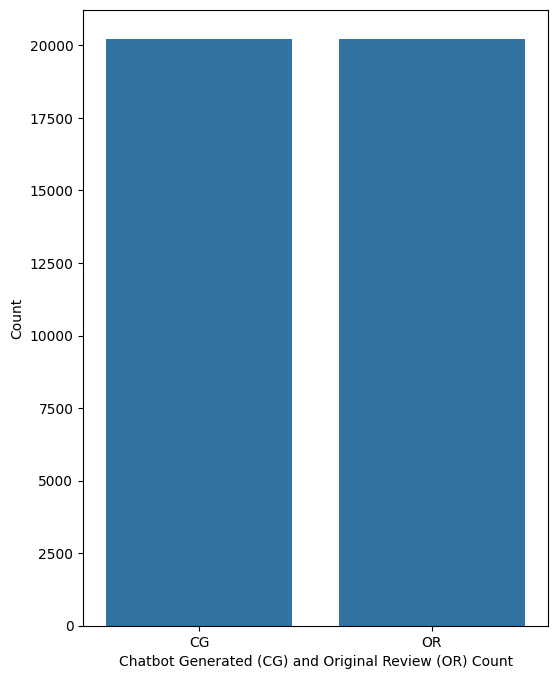

In [9]:
import seaborn as sns
plt.figure(figsize=(6,8))
counts = rawdf.label.value_counts()
sns.barplot(x=counts.index, y=counts)
plt.xlabel('Chatbot Generated (CG) and Original Review (OR) Count')
plt.ylabel('Count')
plt.xticks(rotation=0);

In [10]:
rawdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40432 entries, 0 to 40431
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   category  40432 non-null  object 
 1   rating    40432 non-null  float64
 2   label     40432 non-null  object 
 3   text_     40432 non-null  object 
dtypes: float64(1), object(3)
memory usage: 1.2+ MB


In [11]:
stemmer = PorterStemmer()
stop_words = stopwords.words('english')
def clean_text(text):
  stemmerclean = stemmer.stem(text)
  return stemmerclean
rawdf['text_'] = rawdf['text_'].apply(clean_text)

In [12]:
rawdf = rawdf.drop(columns=['category', 'rating'])

In [13]:
# df = rawdf.drop(["Text_cleaning"], axis=1)
rawdf['label'] = rawdf['label'].str.strip()
rawdf['label'].replace({"CG": 1, "OR": 0}, inplace=True)
rawdf.head()

,label,text_
0,1,"love this! well made, sturdy, and very comfor..."
1,1,"love it, a great upgrade from the original. i..."
2,1,this pillow saved my back. i love the look and...
3,1,"missing information on how to use it, but it i..."
4,1,very nice set. good quality. we have had the s...


In [14]:
rawdf.to_csv('/content/drive/MyDrive/Subs1/fakereviewsdataset.csv', index=False)

In [15]:
rawdf = pd.read_csv("/content/drive/MyDrive/Subs1/fakereviewsdataset.csv")

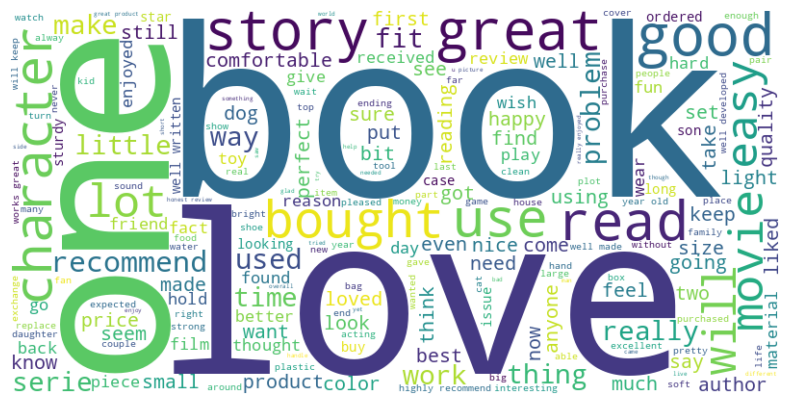

In [16]:
tweet_text = ' '.join(rawdf['text_'])

# Generate word cloud from the tweet text
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(tweet_text)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

# Data Cleansing

In [17]:
rawdf.isnull().sum()

label    0
text_    0
dtype: int64

In [18]:
rawdf.fillna(" ", inplace=True)
rawdf.isna().sum()

label    0
text_    0
dtype: int64

In [ ]:
rawdf.tail()

,label,text_
40427,0,i had read some reviews saying that this bra r...
40428,1,i wasn't sure exactly what it would be. it is ...
40429,0,"you can wear the hood by itself, wear it with ..."
40430,1,i liked nothing about this dress. the only rea...
40431,0,i work in the wedding industry and have to wor...


In [19]:
rawdf.to_csv(os.path.join("/content/drive/MyDrive/Subs1/fakereviewsdataset.csv"), index=False)

# Prepare pipeline

In [20]:
PipelineName = "custom-pipeline"
SchemaPipelineName = "tfdev-schema"
PipelineRoot = os.path.join('fakereviews-pipelines', PipelineName)
MetadataPath= os.path.join('metadata', PipelineName, 'metadata.db')
DirServingModel = os.path.join('serving_model', PipelineName)

In [21]:
Interactive_Context = InteractiveContext(pipeline_root=PipelineRoot)

## Data Ingestion
##### ExampleGen

In [26]:
output = example_gen_pb2.Output(
    split_config=example_gen_pb2.SplitConfig(splits=[
        example_gen_pb2.SplitConfig.Split(name="train", hash_buckets=8),
        example_gen_pb2.SplitConfig.Split(name="eval", hash_buckets=2)
    ])
)
example_gen = CsvExampleGen(input_base="/content/drive/MyDrive/Subs1/Clean", output_config=output)

In [27]:
Interactive_Context.run(example_gen)

ExecutionResult(
    component_id: CsvExampleGen
    execution_id: 3
    outputs:
        examples: OutputChannel(artifact_type=Examples, producer_component_id=CsvExampleGen, output_key=examples, additional_properties={}, additional_custom_properties={}, _input_trigger=None, _is_async=False))

## Data Validation
##### StatisticsGen

In [28]:
statistics_gen = StatisticsGen(
    examples=example_gen.outputs["examples"]
)

Interactive_Context.run(statistics_gen)

ExecutionResult(
    component_id: StatisticsGen
    execution_id: 4
    outputs:
        statistics: OutputChannel(artifact_type=ExampleStatistics, producer_component_id=StatisticsGen, output_key=statistics, additional_properties={}, additional_custom_properties={}, _input_trigger=None, _is_async=False))

In [29]:
Interactive_Context.show(statistics_gen.outputs["statistics"])

## Data Schema
##### SchemaGen

In [30]:
schema_gen = SchemaGen(statistics=statistics_gen.outputs["statistics"])
Interactive_Context.run(schema_gen)

ExecutionResult(
    component_id: SchemaGen
    execution_id: 5
    outputs:
        schema: OutputChannel(artifact_type=Schema, producer_component_id=SchemaGen, output_key=schema, additional_properties={}, additional_custom_properties={}, _input_trigger=None, _is_async=False))

In [31]:
Interactive_Context.show(schema_gen.outputs["schema"])

,Type,Presence,Valency,Domain
Feature name,,,,
'label',INT,required,,-
'text_',BYTES,required,,-


## Example Validator

In [32]:
example_validator = ExampleValidator(
    statistics=statistics_gen.outputs['statistics'],
    schema=schema_gen.outputs['schema']
)
Interactive_Context.run(example_validator)

ExecutionResult(
    component_id: ExampleValidator
    execution_id: 6
    outputs:
        anomalies: OutputChannel(artifact_type=ExampleAnomalies, producer_component_id=ExampleValidator, output_key=anomalies, additional_properties={}, additional_custom_properties={}, _input_trigger=None, _is_async=False))

In [33]:
Interactive_Context.show(example_validator.outputs['anomalies'])

# Data Preprocessing
##### Transform

In [34]:
TransformPy = "TransformReview.py"

In [35]:
%%writefile {TransformPy}
import keras_tuner as kt
import os
import tensorflow as tf
import tensorflow_transform as tft
import tensorflow_hub as hub
from tfx.components.trainer.fn_args_utils import FnArgs
from tfx.components.tuner.component import TunerFnResult

# Set TFHub cache directory to Google Drive
os.environ['TFHUB_CACHE_DIR'] = '/content/drive/MyDrive/Subs1/hub_cache'
# Load Universal Sentence Encoder from TFHub
embed = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4")
stopwords = ["i", "me", "my", "myself", "we", "our", "ours", "ourselves", "you", "your", "yours", "yourself",
"yourselves", "he", "him", "his", "himself", "she", "her", "hers", "herself", "it", "its", "itself", "they",
"them", "their", "theirs", "themselves", "what", "which", "who", "whom", "this", "that", "these", "those", "am", "is", "are",
"was", "were", "be", "been", "being", "have", "has", "had", "having", "do", "does", "did", "doing", "a", "an", "the", "and",
"but", "if", "or", "because", "as", "until", "while", "of", "at", "by", "for", "with", "about", "against", "between", "into",
"through", "during", "before", "after", "above", "below", "to", "from", "up", "down", "in", "out", "on", "off", "over", "under",
"again", "further", "then", "once", "here", "there", "when", "where", "why", "how", "all", "any", "both", "each", "few", "more",
"most", "other", "some", "such", "no", "nor", "not", "only", "own", "same", "so", "than", "too", "very", "s", "t", "can", "will",
"just", "don", "should", "now"]
LABEL_KEY = "label"
FEATURE_KEY = "text_"
VOCAB_SIZE = 1000
SEQ_LENGTH = 100
TRAIN_BATCH_SIZE = 32
EVAL_BATCH_SIZE = 32

def transformed_name(key):
  return key + "_xf"

def preprocessing_fn(inputs):
    outputs = {}
    feature_key = tf.strings.lower(inputs[FEATURE_KEY])
    feature_key = tf.strings.regex_replace(feature_key, r"(?:<br />)", "")
    feature_key = tf.strings.regex_replace(feature_key, "n\'t", " not ")
    feature_key = tf.strings.regex_replace(feature_key, r"(?:\'ll |\'re |\'d |\'ve)", " ")
    feature_key = tf.strings.regex_replace(feature_key, r"\W+", " ")
    feature_key = tf.strings.regex_replace(feature_key, r"\d+", " ")
    feature_key = tf.strings.regex_replace(feature_key, r"\b[a-zA-Z]\b", " ")
    outputs[transformed_name(FEATURE_KEY)] = tf.strings.regex_replace(feature_key, r'\b(' + r'|'.join(stopwords) + r')\b\s*', "")
    outputs[transformed_name(LABEL_KEY)] = tf.cast(inputs[LABEL_KEY], tf.int64)
    return outputs


Writing TransformReview.py


In [ ]:
# import os
# dir_path = r"Review-pipelines\\custom-pipeline\\Transform\\transform_graph\\8\\.temp_path\\tftransform_tmp"
# os.makedirs(dir_path, exist_ok=True)


# "Review-pipelines\custom-pipeline\Transform\transform_graph\7\.temp_path\tftransform_tmp\32dd2803c8664ea6b4da19332b4e3439\variables\variables_temp/part-00000-of-00001.data-00000-of-00001

In [36]:
transform = Transform(
    examples = example_gen.outputs["examples"],
    schema = schema_gen.outputs["schema"],
    module_file = os.path.abspath(TransformPy)
)

In [37]:
Interactive_Context.run(transform)

ExecutionResult(
    component_id: Transform
    execution_id: 7
    outputs:
        transform_graph: OutputChannel(artifact_type=TransformGraph, producer_component_id=Transform, output_key=transform_graph, additional_properties={}, additional_custom_properties={}, _input_trigger=None, _is_async=False)
        transformed_examples: OutputChannel(artifact_type=Examples, producer_component_id=Transform, output_key=transformed_examples, additional_properties={}, additional_custom_properties={}, _input_trigger=None, _is_async=False)
        updated_analyzer_cache: OutputChannel(artifact_type=TransformCache, producer_component_id=Transform, output_key=updated_analyzer_cache, additional_properties={}, additional_custom_properties={}, _input_trigger=None, _is_async=False)
        pre_transform_schema: OutputChannel(artifact_type=Schema, producer_component_id=Transform, output_key=pre_transform_schema, additional_properties={}, additional_custom_properties={}, _input_trigger=None, _is_async=False)
        pre_transform_stats: OutputChannel(artifact_type=ExampleStatistics, producer_component_id=Transform, output_key=pre_transform_stats, additional_properties={}, additional_custom_properties={}, _input_trigger=None, _is_async=False)
        post_transform_schema: OutputChannel(artifact_type=Schema, producer_component_id=Transform, output_key=post_transform_schema, additional_properties={}, additional_custom_properties={}, _input_trigger=None, _is_async=False)
        post_transform_stats: OutputChannel(artifact_type=ExampleStatistics, producer_component_id=Transform, output_key=post_transform_stats, additional_properties={}, additional_custom_properties={}, _input_trigger=None, _is_async=False)
        post_transform_anomalies: OutputChannel(artifact_type=ExampleAnomalies, producer_component_id=Transform, output_key=post_transform_anomalies, additional_properties={}, additional_custom_properties={}, _input_trigger=None, _is_async=False))

# Hyperparameter

In [38]:
TunerPy = "TunerReview.py"

In [42]:
%%writefile {TunerPy}
import keras_tuner as kt
import tensorflow as tf
import tensorflow_transform as tft
from typing import NamedTuple, Dict, Text, Any
from keras_tuner.engine import base_tuner
from tensorflow.keras import layers
from tfx.components.trainer.fn_args_utils import FnArgs

LABEL_KEY = "label"
FEATURE_KEY = "text_"

Epochs = 15

TunerFnResult = NamedTuple("TunerFnResult", [
    ("tuner", base_tuner.BaseTuner),
    ("fit_kwargs", Dict[Text, Any]),
])

early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_binary_accuracy",
    mode="max",
    verbose=1,
    patience=15,
)

def transformed_name(key):
    return f"{key}_xf"

def gzip_reader_fn(filenames):
    return tf.data.TFRecordDataset(filenames, compression_type="GZIP")

def input_fn(file_pattern, tf_transform_output, num_epochs, batch_size=64):
    transform_feature_spec = (
        tf_transform_output.transformed_feature_spec().copy()
    )

    dataset = tf.data.experimental.make_batched_features_dataset(
        file_pattern=file_pattern,
        batch_size=batch_size,
        features=transform_feature_spec,
        reader=gzip_reader_fn,
        num_epochs=num_epochs,
        label_key=transformed_name(LABEL_KEY),
    )

    return dataset


def model_builder(hp, vectorizer_layer):
    num_hidden_layers = hp.Choice(
        "num_hidden_layers", values=[1, 2]
    )
    embed_dims = hp.Int(
        "embed_dims", min_value=16, max_value=128, step=32
    )
    lstm_units = hp.Int(
        "lstm_units", min_value=32, max_value=128, step=32
    )
    dense_units = hp.Int(
        "dense_units", min_value=32, max_value=256, step=32
    )
    dropout_rate = hp.Float(
        "dropout_rate", min_value=0.1, max_value=0.5, step=0.1
    )
    learning_rate = hp.Choice(
        "learning_rate", values=[1e-2, 1e-3, 1e-4]
    )

    inputs = tf.keras.Input(
        shape=(1,), name=transformed_name(FEATURE_KEY), dtype=tf.string
    )

    x = vectorizer_layer(inputs)
    x = layers.Embedding(input_dim=10000, output_dim=embed_dims)(x)
    x = layers.Bidirectional(layers.LSTM(lstm_units))(x)

    for _ in range(num_hidden_layers):
        x = layers.Dense(dense_units, activation=tf.nn.relu)(x)
        x = layers.Dropout(dropout_rate)(x)

    outputs = layers.Dense(1, activation=tf.nn.sigmoid)(x)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
        metrics=["binary_accuracy"],
    )

    return model


def tuner_fn(fn_args: FnArgs):
    tf_transform_output = tft.TFTransformOutput(fn_args.transform_graph_path)

    train_set = input_fn(
        fn_args.train_files[0], tf_transform_output, Epochs
    )

    eval_set = input_fn(
        fn_args.eval_files[0], tf_transform_output, Epochs
    )

    vectorizer_dataset = train_set.map(
        lambda f, l: f[transformed_name(FEATURE_KEY)]
    )

    vectorizer_layer = layers.TextVectorization(
        max_tokens=10000,
        output_mode="int",
        output_sequence_length=500,
    )
    vectorizer_layer.adapt(vectorizer_dataset)


    tuner = kt.RandomSearch(
        hypermodel=lambda hp: model_builder(hp, vectorizer_layer),
        objective=kt.Objective('binary_accuracy', direction='max'),
        max_trials = 4,
        directory=fn_args.working_dir,
        project_name="kt_RandomSearch",
    )

    return TunerFnResult(
        tuner=tuner,
        fit_kwargs={
            "callbacks": [early_stopping_callback],
            "x": train_set,
            "validation_data": eval_set,
            "steps_per_epoch": fn_args.train_steps,
            "validation_steps": fn_args.eval_steps,
        },
    )

Overwriting TunerReview.py


In [43]:
tuner = Tuner(
    module_file=os.path.abspath(TunerPy),
    examples=transform.outputs["transformed_examples"],
    transform_graph=transform.outputs["transform_graph"],
    schema=schema_gen.outputs["schema"],
    train_args=trainer_pb2.TrainArgs(splits=["train"], num_steps=10),
    eval_args=trainer_pb2.EvalArgs(splits=["eval"], num_steps=5),
)

In [44]:
Interactive_Context.run(tuner)

Trial 4 Complete [00h 00m 12s]
binary_accuracy: 0.48124998807907104

Best binary_accuracy So Far: 0.512499988079071
Total elapsed time: 00h 00m 40s
Results summary
Results in fakereviews-pipelines/custom-pipeline/.temp/9/kt_RandomSearch
Showing 10 best trials
Objective(name="binary_accuracy", direction="max")

Trial 2 summary
Hyperparameters:
num_hidden_layers: 2
embed_dims: 112
lstm_units: 32
dense_units: 192
dropout_rate: 0.4
learning_rate: 0.0001
Score: 0.512499988079071

Trial 0 summary
Hyperparameters:
num_hidden_layers: 1
embed_dims: 80
lstm_units: 32
dense_units: 96
dropout_rate: 0.2
learning_rate: 0.0001
Score: 0.5

Trial 3 summary
Hyperparameters:
num_hidden_layers: 2
embed_dims: 80
lstm_units: 32
dense_units: 160
dropout_rate: 0.2
learning_rate: 0.001
Score: 0.48124998807907104

Trial 1 summary
Hyperparameters:
num_hidden_layers: 1
embed_dims: 112
lstm_units: 96
dense_units: 64
dropout_rate: 0.2
learning_rate: 0.001
Score: 0.4781250059604645


ExecutionResult(
    component_id: Tuner
    execution_id: 9
    outputs:
        best_hyperparameters: OutputChannel(artifact_type=HyperParameters, producer_component_id=Tuner, output_key=best_hyperparameters, additional_properties={}, additional_custom_properties={}, _input_trigger=None, _is_async=False)
        tuner_results: OutputChannel(artifact_type=TunerResults, producer_component_id=Tuner, output_key=tuner_results, additional_properties={}, additional_custom_properties={}, _input_trigger=None, _is_async=False))

# Model Development

In [45]:
TRAINER_MODULE_FILE = "TrainerReview.py"

In [46]:
%%writefile {TRAINER_MODULE_FILE}

import os
import tensorflow as tf
import tensorflow_transform as tft
from keras import layers
from tfx.components.trainer.fn_args_utils import FnArgs

LABEL_KEY = "label"
FEATURE_KEY = "text_"

early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_binary_accuracy",
    mode="max",
    verbose=1,
    patience=10,
)


def transformed_name(key):
    return key + "_xf"


def gzip_reader_fn(filenames):
    return tf.data.TFRecordDataset(filenames, compression_type='GZIP')


def input_fn(file_pattern,
             tf_transform_output,
             num_epochs,
             batch_size=64) -> tf.data.Dataset:

    # Get post_transform feature spec
    transform_feature_spec = (
        tf_transform_output.transformed_feature_spec().copy())

    # create batches of data
    dataset = tf.data.experimental.make_batched_features_dataset(
        file_pattern=file_pattern,
        batch_size=batch_size,
        features=transform_feature_spec,
        reader=gzip_reader_fn,
        num_epochs=num_epochs,
        label_key=transformed_name(LABEL_KEY))
    return dataset


# os.environ['TFHUB_CACHE_DIR'] = '/hub_chace'
# embed = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4")

VOCAB_SIZE = 10000
SEQUENCE_LENGTH = 100

vectorize_layer = layers.TextVectorization(
    standardize="lower_and_strip_punctuation",
    max_tokens=VOCAB_SIZE,
    output_mode='int',
    output_sequence_length=SEQUENCE_LENGTH)


# import tensorflow_hub as hub
# embedding = hub.load("https://www.kaggle.com/models/google/universal-sentence-encoder/frameworks/TensorFlow2/variations/universal-sentence-encoder/versions/2")

embedding_dim = 16

def model_builder(vectorizer_layer, hyperparameters):
    inputs = tf.keras.Input(
        shape=(1,), name=transformed_name(FEATURE_KEY), dtype=tf.string
    )

    x = vectorizer_layer(inputs)
    x = layers.Embedding(
        input_dim=10000,
        output_dim=hyperparameters["embed_dims"])(x)
    x = layers.Bidirectional(layers.LSTM(hyperparameters["lstm_units"]))(x)

    for _ in range(hyperparameters["num_hidden_layers"]):
        x = layers.Dense(
            hyperparameters["dense_units"],
            activation=tf.nn.relu)(x)
        x = layers.Dropout(hyperparameters["dropout_rate"])(x)

    outputs = layers.Dense(1, activation=tf.nn.sigmoid)(x)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    model.compile(
        optimizer=tf.keras.optimizers.Adam(
            learning_rate=hyperparameters["learning_rate"]),
        loss=tf.keras.losses.BinaryCrossentropy(),
        metrics=[
            tf.keras.metrics.BinaryAccuracy()],
    )

    model.summary()

    return model


def _get_serve_tf_examples_fn(model, tf_transform_output):
    model.tft_layer = tf_transform_output.transform_features_layer()

    @tf.function
    def serve_tf_examples_fn(serialized_tf_examples):
        feature_spec = tf_transform_output.raw_feature_spec()

        feature_spec.pop(LABEL_KEY)

        parsed_features = tf.io.parse_example(serialized_tf_examples, feature_spec)

        transformed_features = model.tft_layer(parsed_features)

        # get predictions using the transformed features
        return model(transformed_features)

    return serve_tf_examples_fn


def run_fn(fn_args: FnArgs) -> None:
    hyperparameters = fn_args.hyperparameters["values"]

    log_dir = os.path.join(os.path.dirname(fn_args.serving_model_dir), "logs")

    tensorboard_callback = tf.keras.callbacks.TensorBoard(
        log_dir=log_dir, update_freq="batch"
    )

    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        fn_args.serving_model_dir,
        monitor="val_binary_accuracy",
        mode="max",
        verbose=1,
        save_best_only=True,
    )

    callbacks = [
        tensorboard_callback,
        early_stopping_callback,
        model_checkpoint_callback
    ]

    tf_transform_output = tft.TFTransformOutput(fn_args.transform_graph_path)

    train_set = input_fn(
        fn_args.train_files,
        tf_transform_output,
        10)

    eval_set = input_fn(
        fn_args.eval_files,
        tf_transform_output,
        10)

    vectorizer_dataset = train_set.map(
        lambda f, l: f[transformed_name(FEATURE_KEY)]
    )

    vectorizer_layer = layers.TextVectorization(
        max_tokens=6000,
        output_mode="int",
        output_sequence_length=500,
    )

    vectorizer_layer.adapt(vectorizer_dataset)

    model = model_builder(vectorizer_layer, hyperparameters)

    model.fit(
        x=train_set,
        steps_per_epoch=fn_args.train_steps,
        validation_data=eval_set,
        validation_steps=fn_args.eval_steps,
        callbacks=callbacks,
        epochs=15,
        verbose=1,
    )

    signatures = {
        "serving_default": _get_serve_tf_examples_fn(
            model, tf_transform_output
        ).get_concrete_function(
            tf.TensorSpec(
                shape=[None],
                dtype=tf.string,
                name="examples",
            )
        )
    }

    model.save(
        fn_args.serving_model_dir,
        save_format="tf",
        signatures=signatures
    )

Writing TrainerReview.py


##### Trainer

In [47]:
from tfx.proto import trainer_pb2

trainer = Trainer(
    module_file=os.path.abspath(TRAINER_MODULE_FILE),
    examples=transform.outputs['transformed_examples'],
    transform_graph=transform.outputs['transform_graph'],
    schema=schema_gen.outputs['schema'],
    hyperparameters=tuner.outputs["best_hyperparameters"],
    train_args=trainer_pb2.TrainArgs(splits=['train']),
    eval_args=trainer_pb2.EvalArgs(splits=['eval'])
)

In [48]:
Interactive_Context.run(trainer)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text__xf (InputLayer)       [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 500)               0         
 Vectorization)                                                  
                                                                 
 embedding_1 (Embedding)     (None, 500, 112)          1120000   
                                                                 
 bidirectional_1 (Bidirecti  (None, 64)                37120     
 onal)                                                           
                                                                 
 dense_3 (Dense)             (None, 192)               12480     
                                                                 
 dropout_2 (Dropout)         (None, 192)               0   

ExecutionResult(
    component_id: Trainer
    execution_id: 10
    outputs:
        model: OutputChannel(artifact_type=Model, producer_component_id=Trainer, output_key=model, additional_properties={}, additional_custom_properties={}, _input_trigger=None, _is_async=False)
        model_run: OutputChannel(artifact_type=ModelRun, producer_component_id=Trainer, output_key=model_run, additional_properties={}, additional_custom_properties={}, _input_trigger=None, _is_async=False))

##### Resolver

In [49]:
from tfx.dsl.components.common.resolver import Resolver
from tfx.dsl.input_resolution.strategies.latest_blessed_model_strategy import LatestBlessedModelStrategy
from tfx.types import Channel
from tfx.types.standard_artifacts import Model, ModelBlessing

model_resolver = Resolver(
    strategy_class=LatestBlessedModelStrategy,
    model=Channel(type=Model),
    model_blessing=Channel(type=ModelBlessing)
).with_id('Latest_blessed_model_resolver')

Interactive_Context.run(model_resolver)

ExecutionResult(
    component_id: Latest_blessed_model_resolver
    execution_id: 11
    outputs:
        model: OutputChannel(artifact_type=Model, producer_component_id=Latest_blessed_model_resolver, output_key=model, additional_properties={}, additional_custom_properties={}, _input_trigger=None, _is_async=False)
        model_blessing: OutputChannel(artifact_type=ModelBlessing, producer_component_id=Latest_blessed_model_resolver, output_key=model_blessing, additional_properties={}, additional_custom_properties={}, _input_trigger=None, _is_async=False))

##### Evaluator

In [50]:
import tensorflow_model_analysis as tfma

eval_config = tfma.EvalConfig(
    model_specs=[tfma.ModelSpec(label_key='label')],
    slicing_specs=[tfma.SlicingSpec()],
    metrics_specs=[
        tfma.MetricsSpec(metrics=[
            tfma.MetricConfig(class_name='ExampleCount'),
            tfma.MetricConfig(class_name='AUC'),
            tfma.MetricConfig(class_name='FalsePositives'),
            tfma.MetricConfig(class_name='TruePositives'),
            tfma.MetricConfig(class_name='FalseNegatives'),
            tfma.MetricConfig(class_name='TrueNegatives'),
            tfma.MetricConfig(class_name='BinaryAccuracy',
                              threshold=tfma.MetricThreshold(
                                  value_threshold=tfma.GenericValueThreshold(
                                      lower_bound={'value': 0.5}
                                ),
                                change_threshold=tfma.GenericChangeThreshold(
                                    direction=tfma.MetricDirection.HIGHER_IS_BETTER,
                                    absolute={'value': 0.0001}
                                )
                              )
                            )
        ])
    ]
)

In [51]:
from tfx.components import Evaluator

evaluator = Evaluator(
    examples=example_gen.outputs['examples'],
    model=trainer.outputs['model'],
    baseline_model=model_resolver.outputs['model'],
    eval_config=eval_config)

In [52]:
Interactive_Context.run(evaluator)

Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


ExecutionResult(
    component_id: Evaluator
    execution_id: 12
    outputs:
        evaluation: OutputChannel(artifact_type=ModelEvaluation, producer_component_id=Evaluator, output_key=evaluation, additional_properties={}, additional_custom_properties={}, _input_trigger=None, _is_async=False)
        blessing: OutputChannel(artifact_type=ModelBlessing, producer_component_id=Evaluator, output_key=blessing, additional_properties={}, additional_custom_properties={}, _input_trigger=None, _is_async=False))

In [53]:
eval_result = evaluator.outputs['evaluation'].get()[0].uri
tfma_result = tfma.load_eval_result(eval_result)
tfma.view.render_slicing_metrics(tfma_result)
tfma.addons.fairness.view.widget_view.render_fairness_indicator(tfma_result)

##### Pusher

In [54]:
from tfx.components import Pusher
from tfx.proto import pusher_pb2

pusher = Pusher(
    model=trainer.outputs['model'],
    model_blessing=evaluator.outputs['blessing'],
    push_destination=pusher_pb2.PushDestination(
        filesystem=pusher_pb2.PushDestination.Filesystem(
            base_directory='serving_model_dir/fakereviews-model'))

)

Interactive_Context.run(pusher)

ExecutionResult(
    component_id: Pusher
    execution_id: 13
    outputs:
        pushed_model: OutputChannel(artifact_type=PushedModel, producer_component_id=Pusher, output_key=pushed_model, additional_properties={}, additional_custom_properties={}, _input_trigger=None, _is_async=False))

In [61]:
!zip -r /content/serving_model_dir.zip /content/serving_model_dir/

  adding: content/serving_model_dir/ (stored 0%)
  adding: content/serving_model_dir/fakereviews-model/ (stored 0%)
  adding: content/serving_model_dir/fakereviews-model/1716094076/ (stored 0%)
  adding: content/serving_model_dir/fakereviews-model/1716094076/variables/ (stored 0%)
  adding: content/serving_model_dir/fakereviews-model/1716094076/variables/variables.data-00000-of-00001 (deflated 29%)
  adding: content/serving_model_dir/fakereviews-model/1716094076/variables/variables.index (deflated 64%)
  adding: content/serving_model_dir/fakereviews-model/1716094076/assets/ (stored 0%)
  adding: content/serving_model_dir/fakereviews-model/1716094076/saved_model.pb (deflated 89%)
  adding: content/serving_model_dir/fakereviews-model/1716094076/fingerprint.pb (stored 0%)
  adding: content/serving_model_dir/fakereviews-model/1716094076/keras_metadata.pb (deflated 88%)


In [62]:
from google.colab import files
files.download("/content/serving_model_dir.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>